<a href="https://colab.research.google.com/github/arya-anne/python/blob/main/kt_t1_p1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
# import tensorflow as tf

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Compiling model...
Building feed-forward neural network...
'build' took 0.108480 s

'compile' took 0.813923 s

Training model...

Step      Train loss              Test loss               Test metric             
0         [4.35e+01, 2.02e-03]    [4.92e+01, 2.02e-03]    [9.72e-01, 3.77e+07]    
Epoch 1: train loss improved from inf to 4.35e+01, saving model to model/model-1.ckpt ...

1000      [2.35e-04, 3.22e-06]    [2.22e-04, 3.22e-06]    [1.54e-03, 2.12e+06]    
Epoch 1000: train loss improved from 4.35e+01 to 2.38e-04, saving model to model/model-1000.ckpt ...

2000      [3.47e-05, 6.38e-09]    [5.96e-05, 6.38e-09]    [9.27e-05, 8.60e+04]    
Epoch 2000: train loss improved from 2.38e-04 to 3.47e-05, saving model to model/model-2000.ckpt ...

3000      [6.60e-06, 2.64e-09]    [2.11e-05, 2.64e-09]    [5.35e-05, 5.22e+04]    
Epoch 3000: train loss improved from 3.47e-05 to 6.60e-06, saving model to model/model-3000.ckpt ...

4000      [1.17e-04, 4.20e-06]    [1.48e-04, 4.20e-06]    

Saving the movie of spectrum to model/movie_spectrum.txt, model/movie_spectrum.gif...



Best model at step 5000:
  train loss: 2.43e-06
  test loss: 1.56e-05
  test metric: [1.46e-04, 1.50e+05]

'train' took 25.437708 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


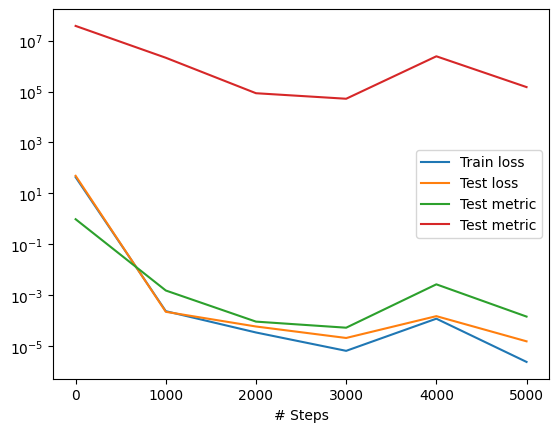

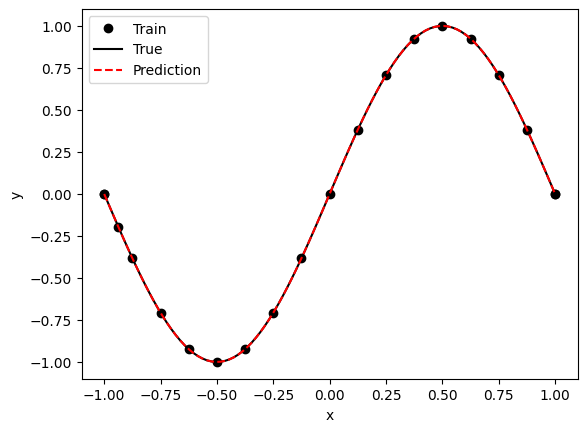

Restoring model from model/model-5000.ckpt ...



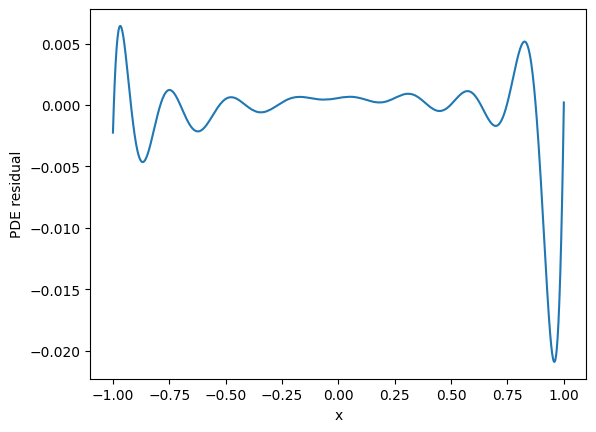

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch
# Import jax.numpy if using backend jax
# import jax.numpy as jnp
# Import paddle if using backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_xx = dde.grad.hessian(y, x)
    # Backend jax
    # dy_xx, _ = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)
    # Use torch.sin for backend pytorch
    # return -dy_xx - np.pi ** 2 * torch.sin(np.pi * x)
    # Use jax.numpy.sin for backend jax
    # return -dy_xx - np.pi ** 2 * jnp.sin(np.pi * x)
    # Use paddle.sin for backend paddle
    # return -dy_xx - np.pi ** 2 * paddle.sin(np.pi * x)


def boundary(x, on_boundary):
    return on_boundary


def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error", "max APE"])

#losshistory, train_state = model.train(iterations=10000)
# Optional: Save the model during training.
checkpointer = dde.callbacks.ModelCheckpoint(
    "model/model", verbose=1, save_better_only=True )
# Optional: Save the movie of the network solution during training.
# ImageMagick (https://imagemagick.org/) is required to generate the movie.
movie = dde.callbacks.MovieDumper(
     "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
  )
losshistory, train_state = model.train(iterations=5000, callbacks=[checkpointer, movie])
#losshistory, train_state = model.train(iterations=5000, callbacks=[checkpointer])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Optional: Restore the saved model with the smallest training loss
model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

In [10]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf
import imageio.v2 as imageio
import matplotlib.ticker as mticker

#frequencies of solution
a = 2
b = 1
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

#precise solution
def u_precise(x):
  return np.sin(a*x[:, 0:1])*np.cos(b*x[:, 1:2])

#right hand side of Laplace equation
def f_right(x):
  return (a**2 + b**2)*tf.sin(a*x[:, 0:1])*tf.cos(b*x[:, 1:2])

def f_r(x):
  return (a**2 + b**2)*np.sin(a*x[:, 0:1])*np.cos(b*x[:, 1:2])

def g(x):
  return np.sin(a*x[:, 0:1])*np.cos(b*x[:, 1:2])

def pde(x, u):
    # Most backends
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    # Backend jax
    # dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    # dy_yy, _ = dde.grad.hessian(y, x, i=1, j=1)
    f = (a**2 + b**2)*tf.sin(a*x[:, 0:1])*tf.cos(b*x[:, 1:2])
    return -du_xx - du_yy - f_right(x)

def boundary(_, on_boundary):
    return on_boundary

def save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename="movie.gif", duration=0.1):
    y = np.linspace(ymin, ymax, Ny_points)
    with imageio.get_writer(filename, mode='I', duration=duration) as writer:
        for i in range(Nx_points):
            fig = plt.figure(figsize=(6, 6))
            plt.plot(y, u[:, i:i+1],  '--', label = 'pred')  # Assuming each frame is a scalar or vector to plot; adjust as needed.
            plt.plot(y, u_pr[:, i:i+1], label='true')
            plt.legend(loc='upper right')
            plt.title(f'Frame {i + 1}')
            plt.xlabel('Y-axis')  # Adjust according to your dimensions
            plt.ylabel('Solution U')
            plt.ylim(-1, 1)
            plt.grid()
            #plt.close()  # Close the plot to avoid displaying it in interactive environments
            # Save the plot to a temporary image
            plt.savefig('temp_plot.png', dpi=fig.dpi)
            writer.append_data(imageio.imread('temp_plot.png'))
            plt.close()  # Close the plot to avoid displaying it in interactive environments

    print(f"Movie saved as {filename}")

def predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points):
  geom = dde.geometry.Rectangle([0, 0], [xmax, ymax])
  #for zero boundary-conditions
  #bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)
  bc = dde.icbc.DirichletBC(geom, g, boundary)
  data = dde.data.PDE(geom, pde, bc, num_domain=40**2, num_boundary=4*40, num_test=300, solution = u_precise)
  net = dde.nn.FNN([2] + [70] * 4 + [1], "tanh", "Glorot uniform")
  model = dde.Model(data, net)
  model.compile("adam", lr=0.001, metrics = ["l2 relative error"])
  #model.compile("adam", lr=0.001)
  # Optional: Save the model during training.
  checkpointer = dde.callbacks.ModelCheckpoint(
      "model/model", verbose=1, save_better_only=True )
  #model.compile("L-BFGS", metrics = ["l2 relative error"])
  #with tf.device('/device:GPU:0'):
  losshistory, train_state = model.train(iterations=N_iter, callbacks=[checkpointer])
  dde.saveplot(losshistory, train_state, issave=True, isplot=True)
  # Optional: Restore the saved model with the smallest training loss
  model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)

  #Number of points for predicted solution
  x = geom.uniform_points(Nx_points*Ny_points, True)
  #alternative way of creating flat array of points for solution evaluation
  #X, Y = np.meshgrid(np.linspace(xmin, xmax, Nx_points), np.linspace(ymin, ymax, Ny_points))
  #x = np.vstack([X.ravel(order = 'F'), Y.ravel(order = 'F')]).T

  #u - predicted solution, u_pr - precise solution

  #call model.predict(x, operator=pde) returns residual of the equation! not the solution itself
  u = model.predict(x).reshape(Nx_points, Ny_points, order='F')
  u_pr = u_precise(x).reshape(Nx_points, Ny_points, order='F')
  residual = model.predict(x, operator=pde).reshape(Nx_points, Ny_points, order='F')

  #eps_l2 = np.linalg.norm(u-u_pr)/np.linalg.norm(u_pr)
  eps_l2 = dde.metrics.l2_relative_error(u_pr, u)
  eps_c = np.max(u-u_pr)
  residual_l2 = np.linalg.norm(residual)/np.linalg.norm(f_r(x))
  residual_c = np.max(residual)

  print("eps_l2 = ", eps_l2)
  print("eps_c = ",eps_c)
  print("residual_l2 = ", residual_l2)
  print("residual_c = ", residual_c)

  return u, u_pr

def plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)

    # Set colormap
    cmap = 'jet'

    # Subplot a)
    im1 = axes[0, 0].imshow(u, extent=[xmin, xmax, ymin, ymax], cmap=cmap)
    axes[0, 0].set_title("a) predicted solution")
    axes[0, 0].set_xlabel("x")
    axes[0, 0].set_ylabel("y")
    axes[0, 0].set_xticks([0, np.pi/2, np.pi])
    axes[0, 0].set_xticklabels(['0', 'π/2', 'π'])
    axes[0, 0].set_yticks([0, np.pi/2, np.pi])
    axes[0, 0].set_yticklabels(['0', 'π/2', 'π'])

    # Subplot b)
    im2 = axes[0, 1].imshow(u_pr, extent=[xmin, xmax, ymin, ymax], cmap=cmap)
    axes[0, 1].set_title("b) precise solution")
    axes[0, 1].set_xticks([0, np.pi/2, np.pi])
    axes[0, 1].set_xticklabels(['0', 'π/2', 'π'])
    axes[0, 1].set_yticks([0, np.pi/2, np.pi])
    axes[0, 1].set_yticklabels(['0', 'π/2', 'π'])
    axes[0, 1].set_xlabel("x")
    axes[0, 1].set_ylabel("y")

    # Subplot c)
    im3 = axes[0, 2].imshow(np.abs(u_pr-u), extent=[xmin, xmax, ymin, ymax], cmap=cmap)
    axes[0, 2].set_title("c) difference")
    axes[0, 2].set_xticks([0, np.pi/2, np.pi])
    axes[0, 2].set_xticklabels(['0', 'π/2', 'π'])
    axes[0, 2].set_yticks([0, np.pi/2, np.pi])
    axes[0, 2].set_yticklabels(['0', 'π/2', 'π'])
    axes[0, 2].set_xlabel("x")
    axes[0, 2].set_ylabel("y")

    # Central colorbar for (a, b, d, e)
    cbar = fig.colorbar(im2, ax=[axes[0, 0], axes[0, 1], axes[0, 2]],
                          pad=0.04, location='right', fraction = 0.053, ticks = mticker.LinearLocator(numticks = 5 ))

    # Subplot d)
    y1 = np.linspace(ymin, ymax, Ny_points)
    #x = 0
    im4 = axes[1, 0].plot(y1, u[:, 0], '--', label = 'pred')
    axes[1, 0].plot(y1, u_pr[:, 0], label = 'true')
    axes[1, 0].legend(loc='upper right')
    axes[1, 0].set_title("d) x = x_min")
    axes[1, 0].set_xticks([0, np.pi/2, np.pi])
    axes[1, 0].set_xticklabels(['0', 'π/2', 'π'])
    axes[1, 0].set_xlabel("y")
    axes[1, 0].set_ylabel("u")

    # Subplot e)
    #x = pi/2
    im5 = axes[1, 1].plot(y1, u[:, Nx_points//2-1], '--', label = 'pred')
    axes[1, 1].plot(y1, u_pr[:, Nx_points//2-1], label = 'true')
    axes[1, 1].legend(loc='upper right')
    axes[1, 1].set_title("e) x = (x_min + x_max)/2")
    axes[1, 1].set_xticks([0, np.pi/2, np.pi])
    axes[1, 1].set_xticklabels(['0', 'π/2', 'π'])
    axes[1, 1].set_xlabel("y")
    axes[1, 1].set_ylabel("u")

    # Subplot f)
    #x = pi
    im6 = axes[1, 2].plot(y1, u[:, Nx_points-1], '--', label = 'pred')
    axes[1, 2].plot(y1, u_pr[:, Nx_points-1], label = 'true')
    axes[1, 2].legend(loc='upper right')
    axes[1, 2].set_title("f) x = x_max")
    axes[1, 2].set_xticks([0, np.pi/2, np.pi])
    axes[1, 2].set_xticklabels(['0', 'π/2', 'π'])
    axes[1, 2].set_xlabel("y")
    axes[1, 2].set_ylabel("u")

Compiling model...
Building feed-forward neural network...
'build' took 0.112250 s

'compile' took 0.785934 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [6.27e+00, 3.37e-01]    [6.26e+00, 3.37e-01]    [1.18e+00]    
Epoch 1: train loss improved from inf to 6.61e+00, saving model to model/model-1.ckpt ...

1000      [2.23e-03, 1.07e-03]    [1.83e-03, 1.07e-03]    [6.45e-02]    
Epoch 1000: train loss improved from 6.61e+00 to 3.29e-03, saving model to model/model-1000.ckpt ...

2000      [9.77e-05, 7.60e-05]    [6.74e-05, 7.60e-05]    [1.13e-02]    
Epoch 2000: train loss improved from 3.29e-03 to 1.74e-04, saving model to model/model-2000.ckpt ...

3000      [9.31e-05, 6.18e-05]    [6.91e-05, 6.18e-05]    [1.07e-02]    
Epoch 3000: train loss improved from 1.74e-04 to 1.55e-04, saving model to model/model-3000.ckpt ...

4000      [4.81e-05, 4.51e-05]    [3.12e-05, 4.51e-05]    [9.37e-03]    
Epoch 4000: train loss improved fro

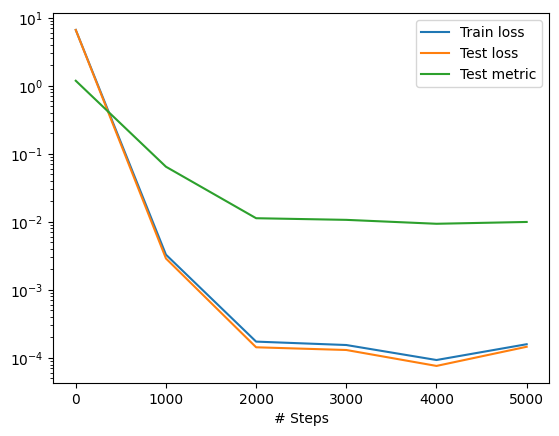

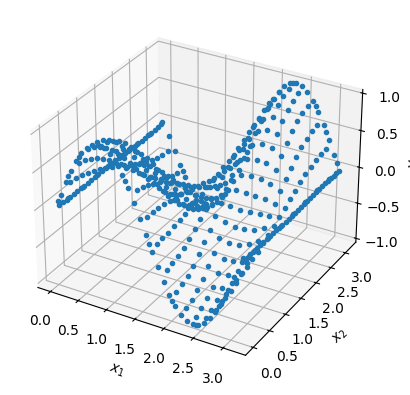

Restoring model from model/model-4000.ckpt ...

eps_l2 =  0.007434097
eps_c =  0.017687783
residual_l2 =  0.00256297
residual_c =  0.06431631
Movie saved as movie_2_1.gif


In [11]:
#frequencies of solution
a = 2
b = 1
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.124235 s

'compile' took 1.084816 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.13e+00, 2.78e-01]    [1.13e+00, 2.78e-01]    [1.11e+00]    
Epoch 1: train loss improved from inf to 1.41e+00, saving model to model/model-1.ckpt ...

1000      [3.15e-04, 2.55e-04]    [1.86e-04, 2.55e-04]    [2.15e-02]    
Epoch 1000: train loss improved from 1.41e+00 to 5.71e-04, saving model to model/model-1000.ckpt ...

2000      [1.01e-04, 9.66e-05]    [6.01e-05, 9.66e-05]    [1.30e-02]    
Epoch 2000: train loss improved from 5.71e-04 to 1.98e-04, saving model to model/model-2000.ckpt ...

3000      [4.37e-05, 3.60e-05]    [2.69e-05, 3.60e-05]    [7.83e-03]    
Epoch 3000: train loss improved from 1.98e-04 to 7.97e-05, saving model to model/model-3000.ckpt ...

4000      [2.94e-05, 1.75e-05]    [1.99e-05, 1.75e-05]    [5.41e-03]    
Epoch 4000: train loss improved fro

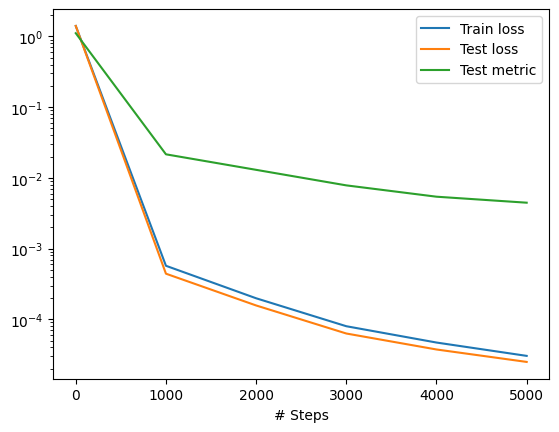

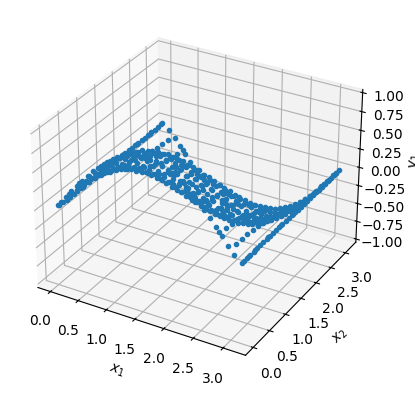

Restoring model from model/model-5000.ckpt ...

eps_l2 =  0.0032934332
eps_c =  0.010003681
residual_l2 =  0.003999164
residual_c =  0.023731712
Movie saved as movie_1_1.gif


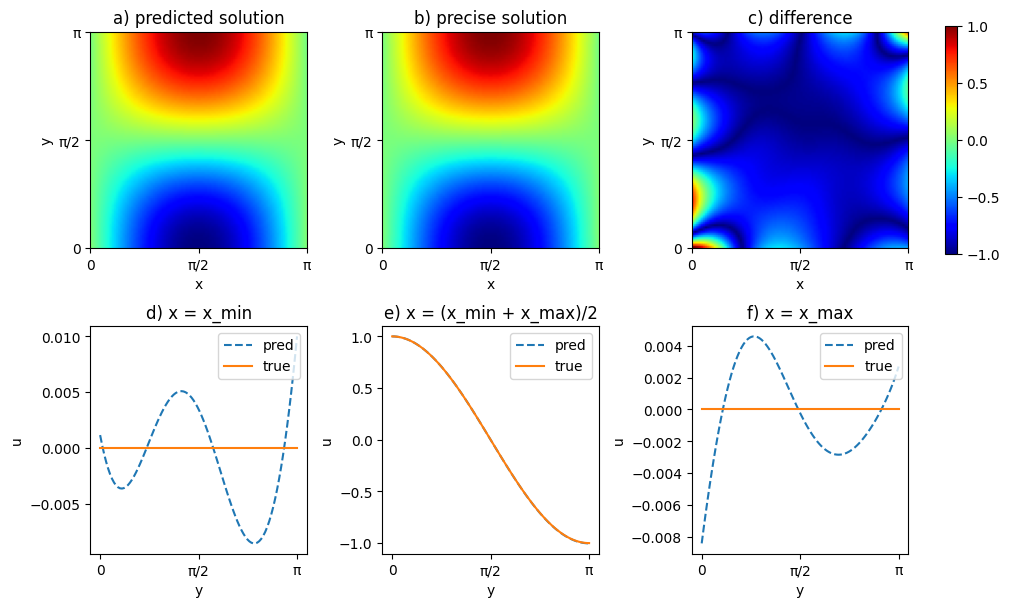

In [13]:
#frequencies of solution
a = 1
b = 1
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.092844 s

'compile' took 1.527531 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.10e+02, 3.37e-01]    [2.10e+02, 3.37e-01]    [1.20e+00]    
Epoch 1: train loss improved from inf to 2.11e+02, saving model to model/model-1.ckpt ...

1000      [7.29e-02, 3.23e-02]    [4.52e-02, 3.23e-02]    [2.24e-01]    
Epoch 1000: train loss improved from 2.11e+02 to 1.05e-01, saving model to model/model-1000.ckpt ...

2000      [1.18e+00, 8.78e-03]    [1.36e+00, 8.78e-03]    [1.38e-01]    
3000      [8.95e-03, 3.86e-03]    [5.58e-03, 3.86e-03]    [7.72e-02]    
Epoch 3000: train loss improved from 1.05e-01 to 1.28e-02, saving model to model/model-3000.ckpt ...

4000      [6.18e-03, 2.50e-03]    [3.84e-03, 2.50e-03]    [6.25e-02]    
Epoch 4000: train loss improved from 1.28e-02 to 8.68e-03, saving model to model/model-4000.ckpt ...

5000      [4.13e-03, 1.78e-03]    [

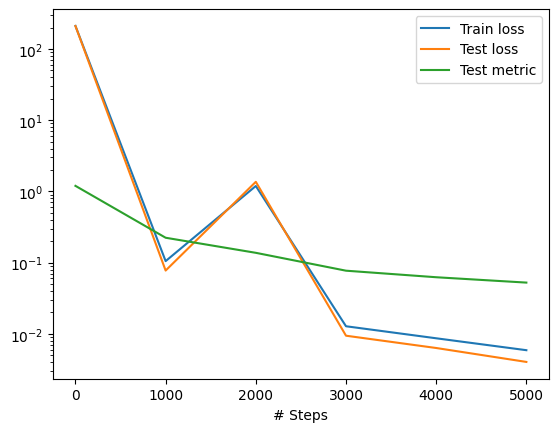

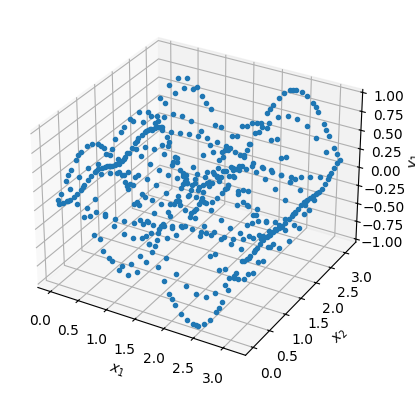

Restoring model from model/model-5000.ckpt ...

eps_l2 =  0.035220064
eps_c =  0.13687919
residual_l2 =  0.0039964207
residual_c =  0.98083717
Movie saved as movie_2_5.gif


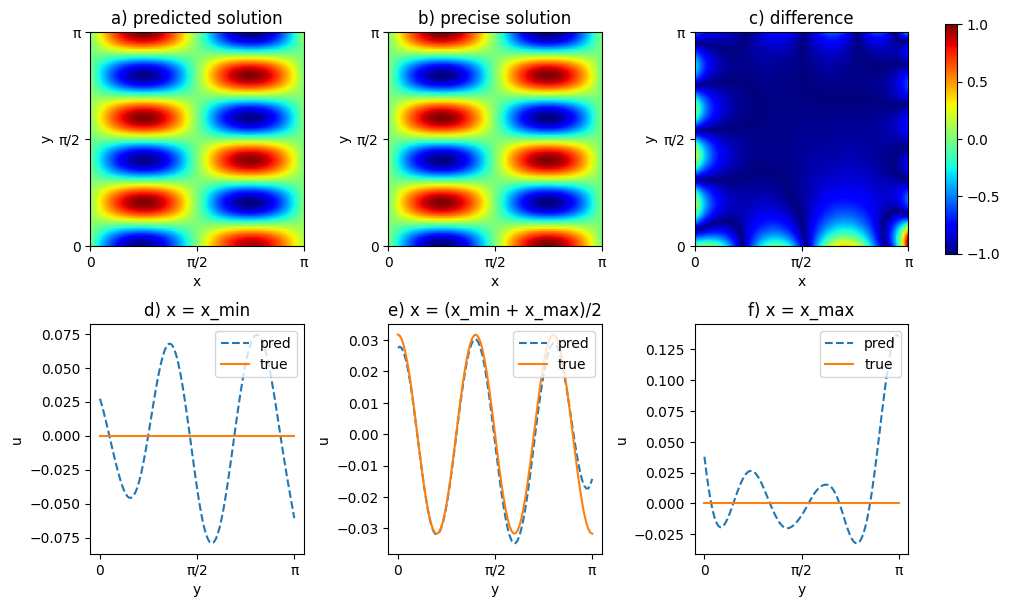

In [14]:
#frequencies of solution
a = 2
b = 5
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.083413 s

'compile' took 0.837112 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [6.27e+02, 3.38e-01]    [6.23e+02, 3.38e-01]    [1.19e+00]    
Epoch 1: train loss improved from inf to 6.28e+02, saving model to model/model-1.ckpt ...

1000      [3.31e-01, 7.64e-02]    [3.42e-01, 7.64e-02]    [3.44e-01]    
Epoch 1000: train loss improved from 6.28e+02 to 4.08e-01, saving model to model/model-1000.ckpt ...

2000      [1.89e-01, 4.36e-02]    [1.79e-01, 4.36e-02]    [2.53e-01]    
Epoch 2000: train loss improved from 4.08e-01 to 2.33e-01, saving model to model/model-2000.ckpt ...

3000      [3.47e-01, 3.18e-02]    [3.11e-01, 3.18e-02]    [2.16e-01]    
4000      [2.69e-02, 2.16e-02]    [2.73e-02, 2.16e-02]    [1.78e-01]    
Epoch 4000: train loss improved from 2.33e-01 to 4.85e-02, saving model to model/model-4000.ckpt ...

5000      [6.12e-02, 1.60e-02]    [

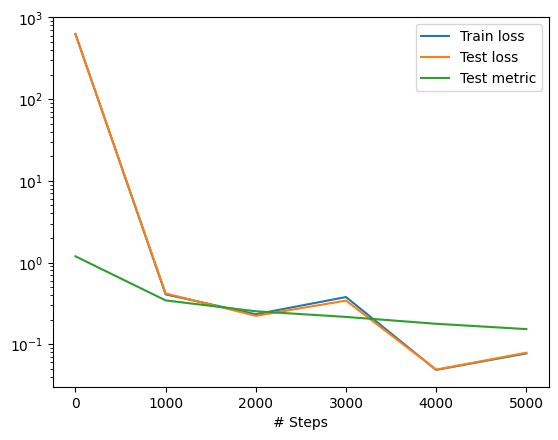

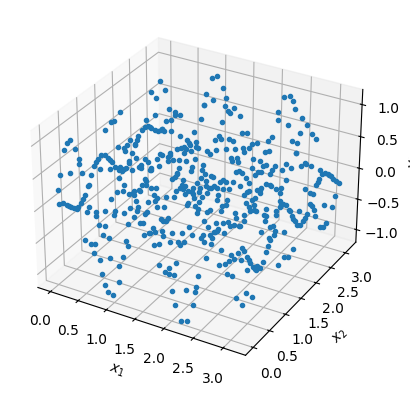

Restoring model from model/model-4000.ckpt ...

eps_l2 =  0.11412722
eps_c =  0.3384517
residual_l2 =  0.006710814
residual_c =  0.83598804
Movie saved as movie_5_5.gif


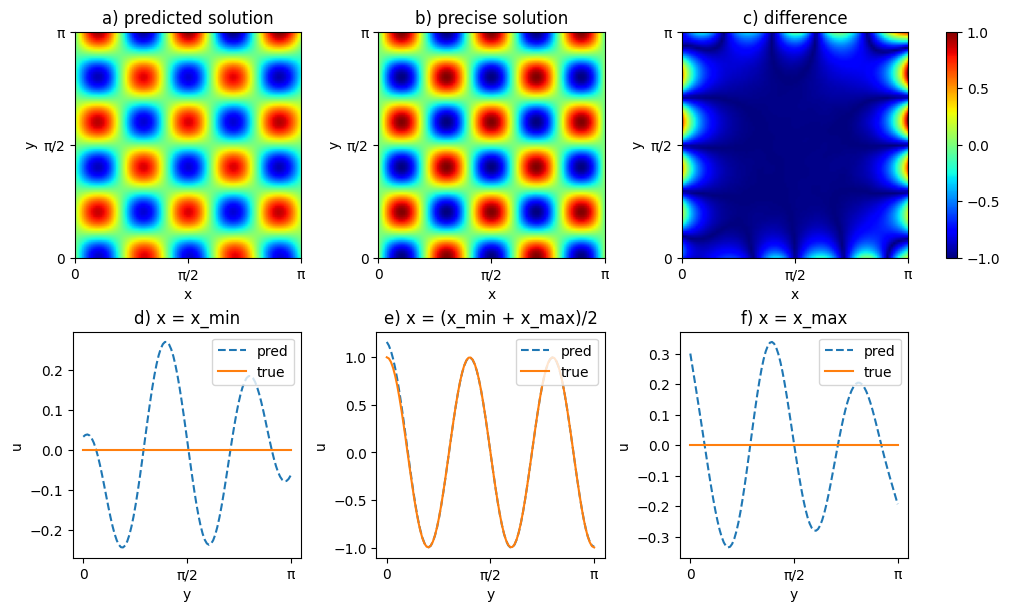

In [15]:
#frequencies of solution
a = 5
b = 5
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.114503 s

'compile' took 0.906610 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.99e+03, 3.93e-01]    [1.97e+03, 3.93e-01]    [1.22e+00]    
Epoch 1: train loss improved from inf to 1.99e+03, saving model to model/model-1.ckpt ...

1000      [4.92e+01, 6.92e-01]    [4.20e+01, 6.92e-01]    [1.47e+00]    
Epoch 1000: train loss improved from 1.99e+03 to 4.99e+01, saving model to model/model-1000.ckpt ...

2000      [1.10e+00, 1.18e-01]    [3.19e-01, 1.18e-01]    [4.26e-01]    
Epoch 2000: train loss improved from 4.99e+01 to 1.21e+00, saving model to model/model-2000.ckpt ...

3000      [8.84e-01, 7.41e-02]    [5.03e-01, 7.41e-02]    [3.34e-01]    
Epoch 3000: train loss improved from 1.21e+00 to 9.58e-01, saving model to model/model-3000.ckpt ...

4000      [2.17e-01, 5.96e-02]    [1.06e-01, 5.96e-02]    [2.97e-01]    
Epoch 4000: train loss improved fro

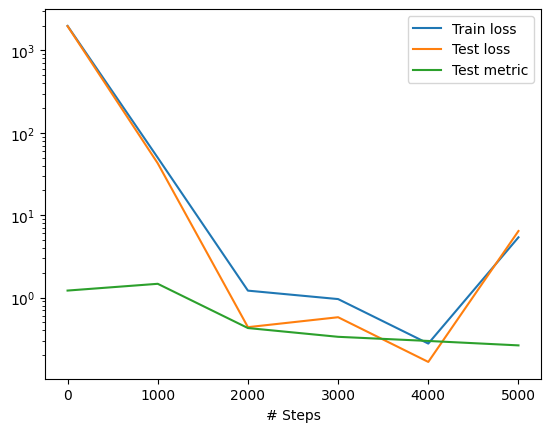

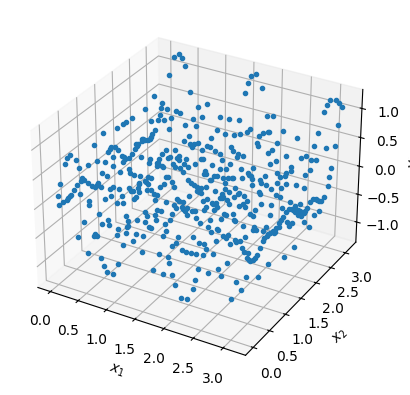

Restoring model from model/model-4000.ckpt ...

eps_l2 =  0.18861242
eps_c =  1.0642892
residual_l2 =  0.010392043
residual_c =  5.6580825
Movie saved as movie_5_8.gif


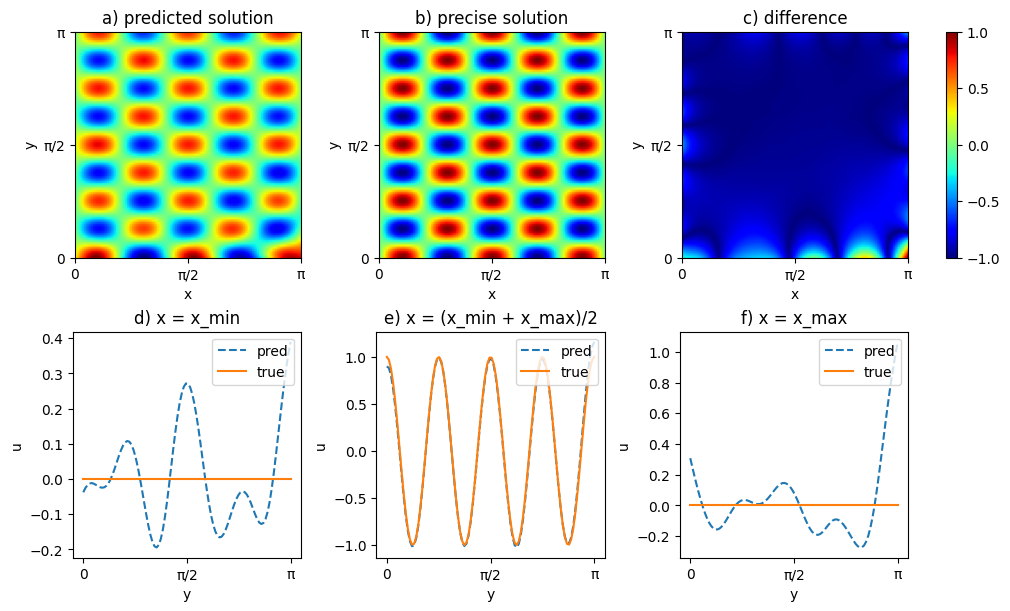

In [16]:
#frequencies of solution
a = 5
b = 8
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.113007 s

'compile' took 1.470845 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.92e+03, 3.93e-01]    [3.89e+03, 3.93e-01]    [1.22e+00]    
Epoch 1: train loss improved from inf to 3.92e+03, saving model to model/model-1.ckpt ...

1000      [3.79e+02, 8.77e-01]    [3.15e+02, 8.77e-01]    [1.42e+00]    
Epoch 1000: train loss improved from 3.92e+03 to 3.80e+02, saving model to model/model-1000.ckpt ...

2000      [6.24e+00, 4.67e-01]    [3.85e+00, 4.67e-01]    [9.09e-01]    
Epoch 2000: train loss improved from 3.80e+02 to 6.71e+00, saving model to model/model-2000.ckpt ...

3000      [4.34e+01, 1.79e-01]    [5.03e+01, 1.79e-01]    [5.32e-01]    
4000      [8.17e-01, 1.17e-01]    [6.60e-01, 1.17e-01]    [4.19e-01]    
Epoch 4000: train loss improved from 6.71e+00 to 9.34e-01, saving model to model/model-4000.ckpt ...

5000      [4.71e-01, 7.97e-02]    [

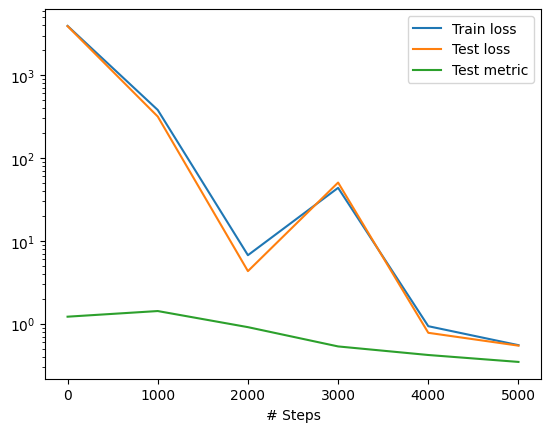

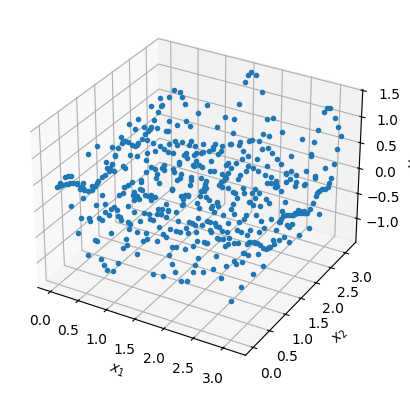

Restoring model from model/model-5000.ckpt ...

eps_l2 =  0.2267918
eps_c =  0.6854244
residual_l2 =  0.0113955755
residual_c =  9.765794
Movie saved as movie_5_10.gif


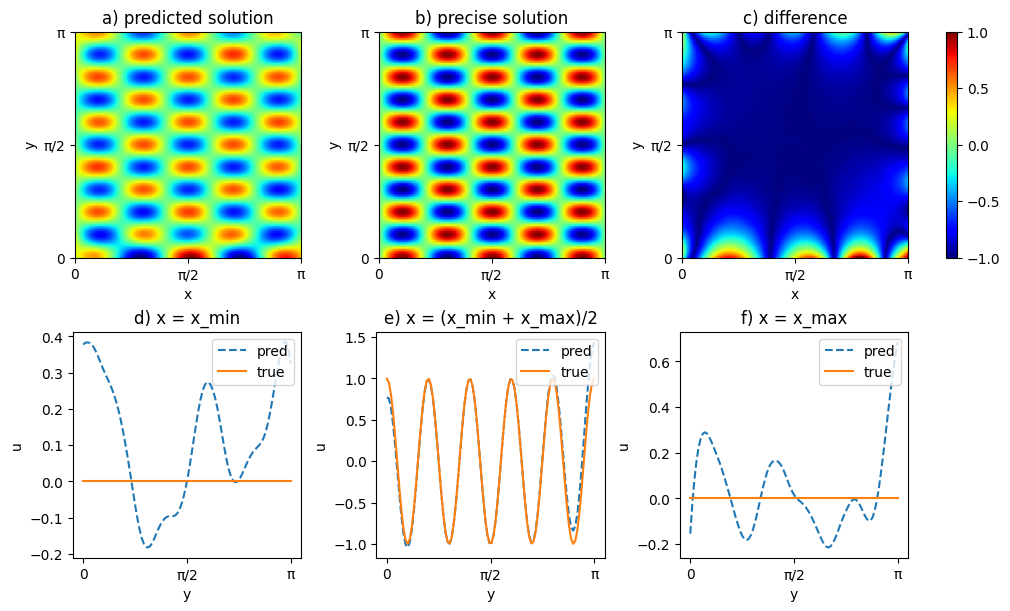

In [21]:
#frequencies of solution
a = 5
b = 10
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.088259 s

'compile' took 0.915231 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.06e+03, 3.13e-01]    [4.08e+03, 3.13e-01]    [1.21e+00]    
Epoch 1: train loss improved from inf to 4.06e+03, saving model to model/model-1.ckpt ...

1000      [2.16e+03, 9.44e+00]    [2.86e+03, 9.44e+00]    [5.42e+00]    
Epoch 1000: train loss improved from 4.06e+03 to 2.17e+03, saving model to model/model-1000.ckpt ...

2000      [1.57e+03, 7.94e-01]    [2.49e+03, 7.94e-01]    [1.64e+00]    
Epoch 2000: train loss improved from 2.17e+03 to 1.57e+03, saving model to model/model-2000.ckpt ...

3000      [1.25e+03, 1.10e+00]    [2.52e+03, 1.10e+00]    [1.66e+00]    
Epoch 3000: train loss improved from 1.57e+03 to 1.25e+03, saving model to model/model-3000.ckpt ...

4000      [1.09e+03, 2.83e+00]    [2.73e+03, 2.83e+00]    [2.63e+00]    
Epoch 4000: train loss improved fro

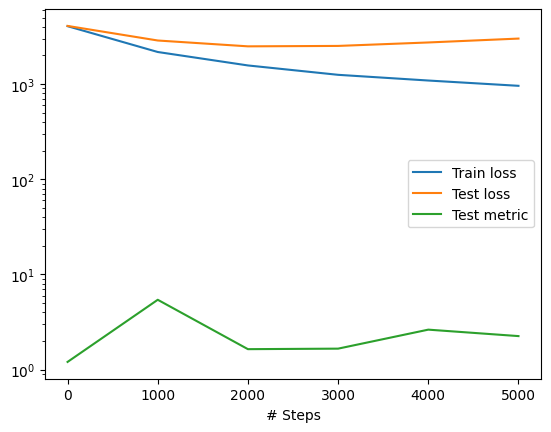

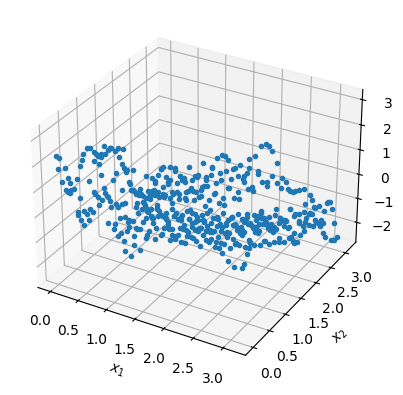

Restoring model from model/model-5000.ckpt ...

eps_l2 =  2.0730875
eps_c =  2.5703373
residual_l2 =  0.83495134
residual_c =  247.66293
Movie saved as movie_8_8.gif


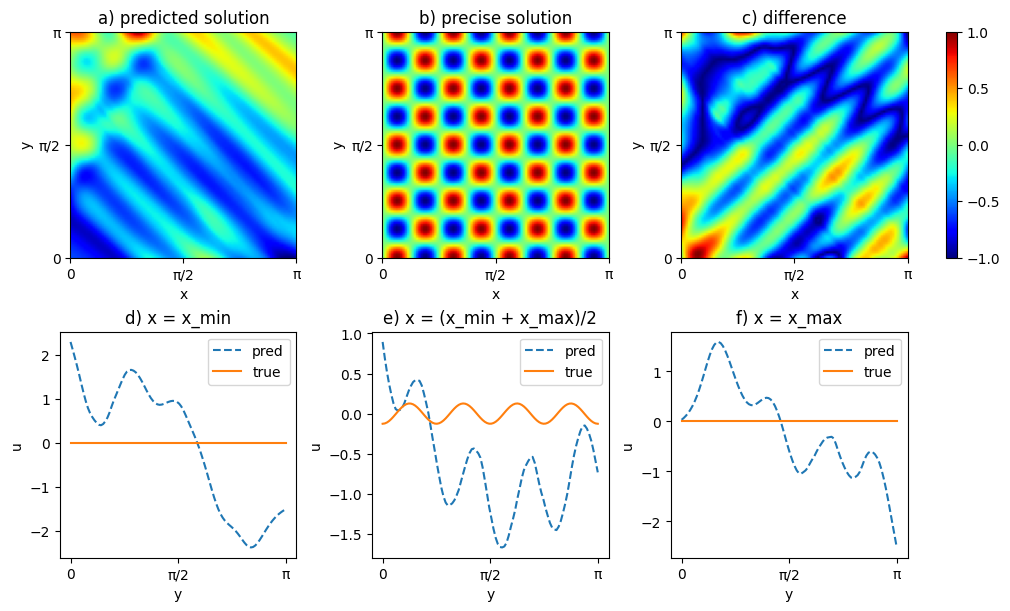

In [17]:
#frequencies of solution
a = 8
b = 8
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.111926 s

'compile' took 0.953047 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.00e+04, 3.46e-01]    [9.97e+03, 3.46e-01]    [1.20e+00]    
Epoch 1: train loss improved from inf to 1.00e+04, saving model to model/model-1.ckpt ...

1000      [5.35e+03, 5.99e+00]    [6.87e+03, 5.99e+00]    [3.91e+00]    
Epoch 1000: train loss improved from 1.00e+04 to 5.36e+03, saving model to model/model-1000.ckpt ...

2000      [4.10e+03, 1.45e+00]    [6.78e+03, 1.45e+00]    [1.98e+00]    
Epoch 2000: train loss improved from 5.36e+03 to 4.10e+03, saving model to model/model-2000.ckpt ...

3000      [3.22e+03, 3.96e+00]    [6.37e+03, 3.96e+00]    [3.21e+00]    
Epoch 3000: train loss improved from 4.10e+03 to 3.22e+03, saving model to model/model-3000.ckpt ...

4000      [2.92e+03, 8.00e+00]    [7.32e+03, 8.00e+00]    [4.54e+00]    
Epoch 4000: train loss improved fro

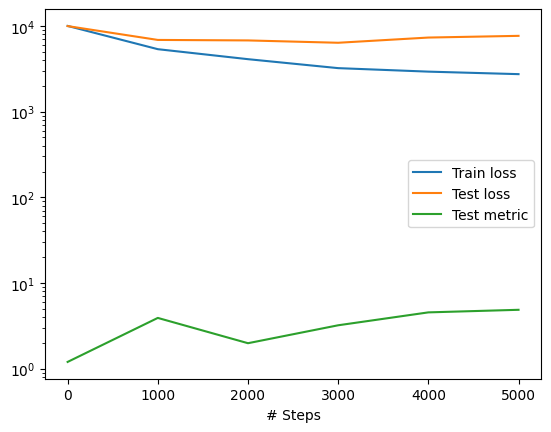

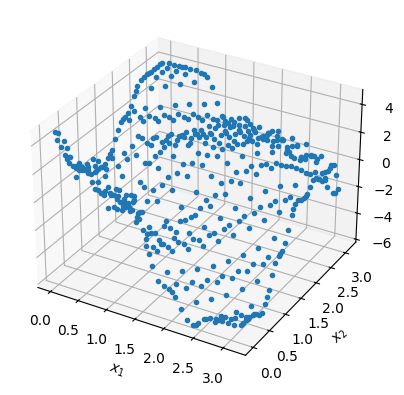

Restoring model from model/model-5000.ckpt ...

eps_l2 =  4.486146
eps_c =  4.9163427
residual_l2 =  0.8675884
residual_c =  656.4292
Movie saved as movie_10_10.gif


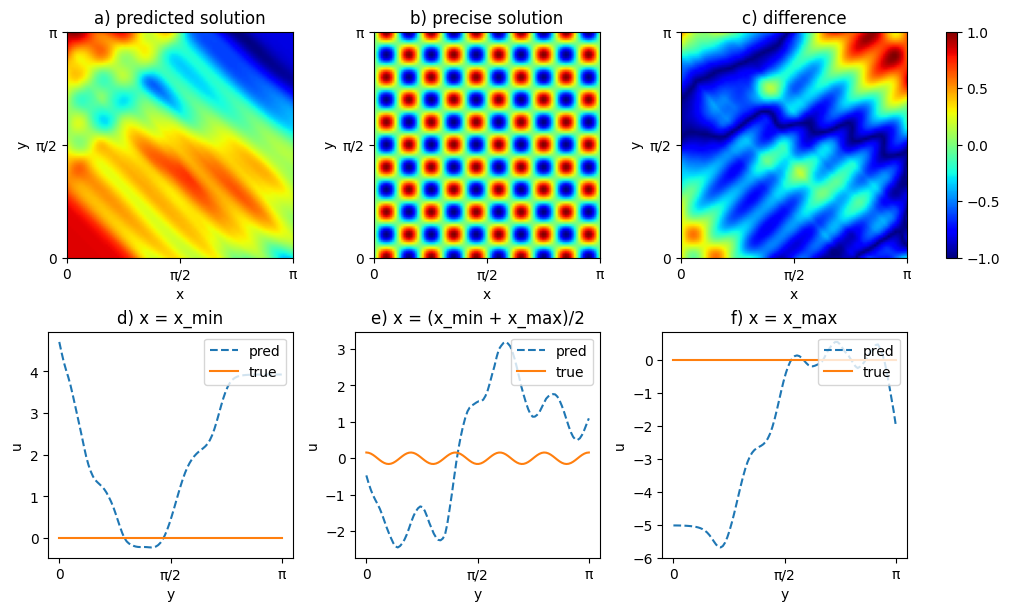

In [18]:
#frequencies of solution
a = 10
b = 10
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.147501 s

'compile' took 1.067060 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.07e+04, 3.13e-01]    [1.08e+04, 3.13e-01]    [1.21e+00]    
Epoch 1: train loss improved from inf to 1.07e+04, saving model to model/model-1.ckpt ...

1000      [6.55e+03, 4.63e+00]    [7.04e+03, 4.63e+00]    [4.72e+00]    
Epoch 1000: train loss improved from 1.07e+04 to 6.55e+03, saving model to model/model-1000.ckpt ...

2000      [5.65e+03, 1.43e+00]    [6.87e+03, 1.43e+00]    [2.53e+00]    
Epoch 2000: train loss improved from 6.55e+03 to 5.65e+03, saving model to model/model-2000.ckpt ...

3000      [5.25e+03, 1.73e+00]    [9.68e+03, 1.73e+00]    [3.15e+00]    
Epoch 3000: train loss improved from 5.65e+03 to 5.25e+03, saving model to model/model-3000.ckpt ...

4000      [4.63e+03, 2.19e+00]    [1.30e+04, 2.19e+00]    [4.36e+00]    
Epoch 4000: train loss improved fro

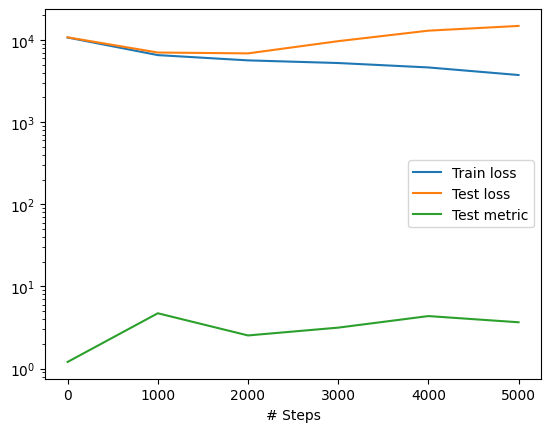

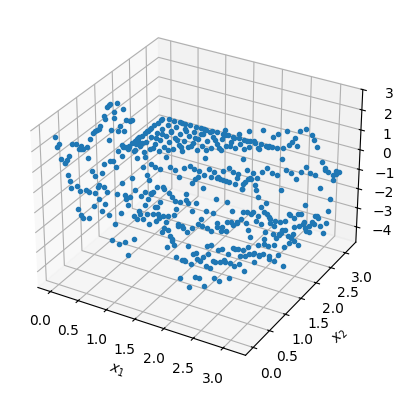

Restoring model from model/model-5000.ckpt ...

eps_l2 =  3.7504315
eps_c =  3.8475192
residual_l2 =  0.9996676
residual_c =  756.90906
Movie saved as movie_8_12.gif


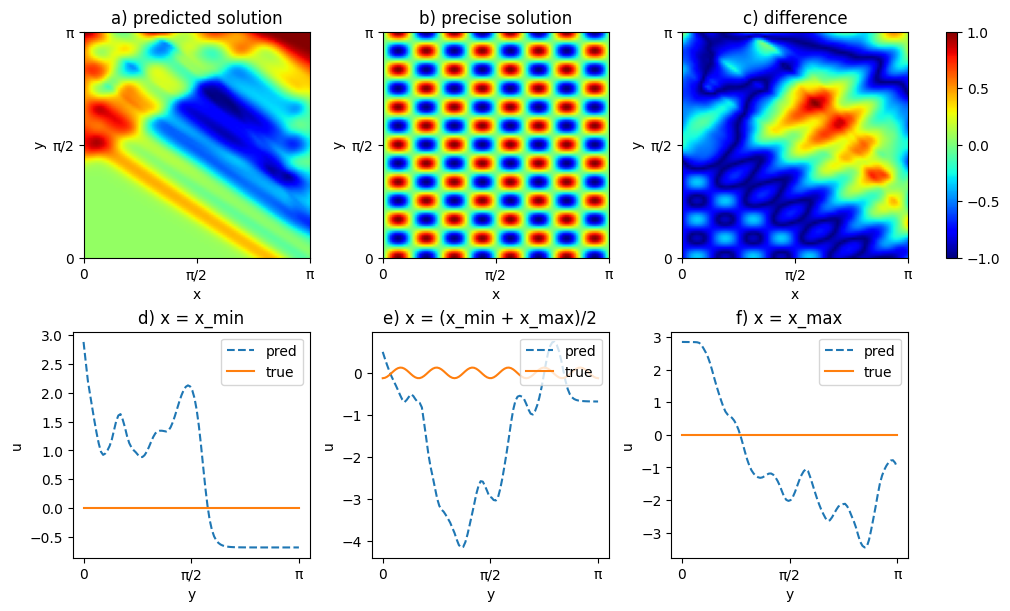

In [19]:
#frequencies of solution
a = 8
b = 12
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)

Compiling model...
Building feed-forward neural network...
'build' took 0.099717 s

'compile' took 1.051278 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [5.07e+04, 3.53e-01]    [5.05e+04, 3.53e-01]    [1.20e+00]    
Epoch 1: train loss improved from inf to 5.07e+04, saving model to model/model-1.ckpt ...

1000      [3.76e+04, 6.25e+00]    [3.98e+04, 6.25e+00]    [4.63e+00]    
Epoch 1000: train loss improved from 5.07e+04 to 3.76e+04, saving model to model/model-1000.ckpt ...

2000      [3.07e+04, 6.39e+00]    [3.79e+04, 6.39e+00]    [4.76e+00]    
Epoch 2000: train loss improved from 3.76e+04 to 3.07e+04, saving model to model/model-2000.ckpt ...

3000      [2.77e+04, 4.77e+00]    [3.85e+04, 4.77e+00]    [4.21e+00]    
Epoch 3000: train loss improved from 3.07e+04 to 2.77e+04, saving model to model/model-3000.ckpt ...

4000      [2.51e+04, 7.57e+00]    [3.95e+04, 7.57e+00]    [5.73e+00]    
Epoch 4000: train loss improved fro

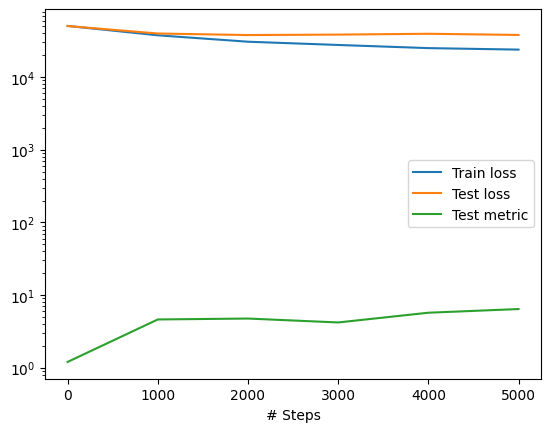

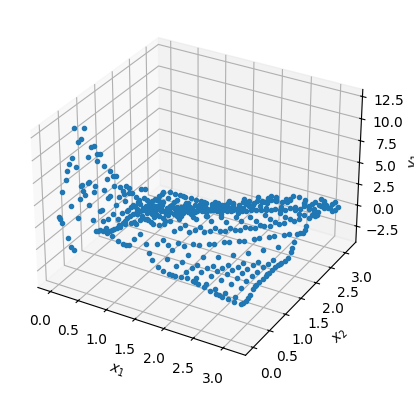

Restoring model from model/model-5000.ckpt ...

eps_l2 =  6.545267
eps_c =  13.920161
residual_l2 =  1.2822617
residual_c =  4652.0005
Movie saved as movie_15_15.gif


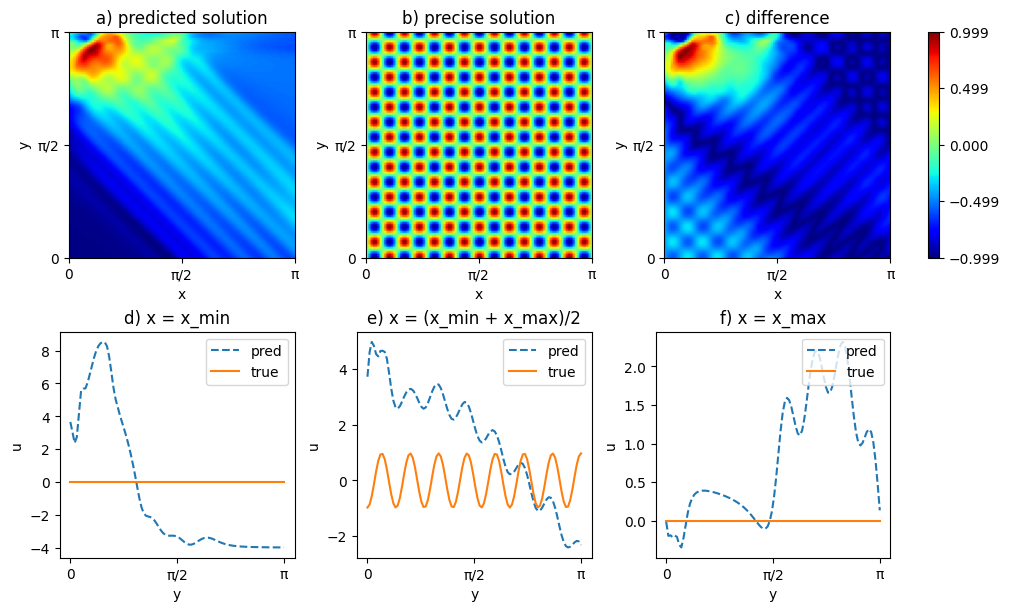

In [20]:
#frequencies of solution
a = 15
b = 15
#domain boundaries
xmax = np.pi
ymax = np.pi
xmin = 0
ymin = 0
#number of iterations for training
N_iter = 5000
Nx_points = 100
Ny_points = 100

u, u_pr = predict_u_with_PINN(a, b, xmin, ymin, xmax, ymax, N_iter, Nx_points, Ny_points)

file_name = "movie_" + str(a) + '_' + str(b) + ".gif"
save_movie(u, u_pr, Nx_points, Ny_points, ymin, ymax, filename=file_name, duration=1)
plot_figures(u, u_pr, xmin, xmax, ymin, ymax, Nx_points, Ny_points)